In this notebook I'll check whether I can reproduce LGal spectra if I feed in the same SFH and ZH to `provabgs`. This is to identify if there are any discrepancies between the SPS model of LGal and `provabgs`

In [1]:
import os
import numpy as np 
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#if 'NERSC_HOST' not in os.environ.keys():
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [2]:
from gqp_mc import data as Data

In [3]:
from provabgs import models as Models
from provabgs import infer as Infer

# read `LGal` spectra

In [41]:
spec_nonoise, meta = Data.Spectra(sim='lgal', noise='none')
spec_noise, _ = Data.Spectra(sim='lgal', noise='bgs')
photo, _ = Data.Photometry(sim='lgal', noise='legacy')

In [5]:
igal = 13

(-1.0, 5.0)

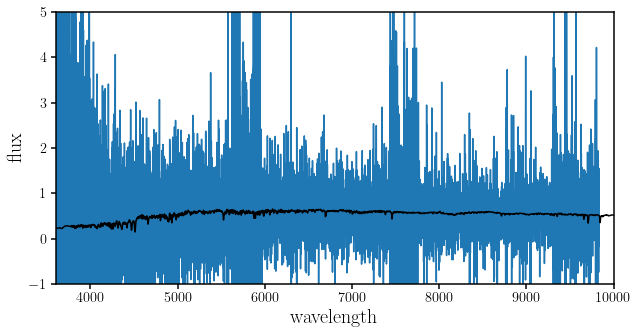

In [34]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(spec_noise['wave'], spec_noise['flux'][igal,:])
sub.plot(spec_nonoise['wave'], spec_nonoise['flux'][igal,:], c='k')
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 1e4)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(-1, 5)

# setup `provabgs`

In [7]:
m_nmf = Models.NMF(burst=True, emulator=True)

# Lets try to reproduce the LGal spectra with `provabgs`

In [8]:
# bestfit from S2
theta_bf = np.array([ 9.09788033e+00,  1.68572232e-01,  8.72346674e-02,  6.84204795e-01,
        5.99883059e-02,  9.63178599e-02,  9.44794564e-01,  7.84027029e-05,
        2.89134312e-03,  2.59285767e+00,  7.55391175e-01, -8.97111831e-01])

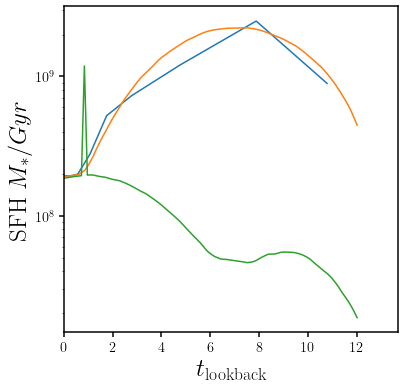

In [9]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.plot(meta['t_lookback'][igal], (meta['sfh_disk'][igal] + meta['sfh_bulge'][igal])/meta['dt'][igal])

theta_i = np.array([
    meta['logM_total'][igal], 
    0.5, 
    0.35, 
    0.05,
    0.1,
    0., 
    0., 
    0, 
    0,
    meta['tau_bc'][igal], 
    meta['tau_ism'][igal], 
    0.
])

t, sfh = m_nmf.SFH(theta_i, zred=meta['redshift'][igal])
sub.plot(t, sfh)
t, sfh = m_nmf.SFH(theta_bf, zred=meta['redshift'][igal])
sub.plot(t, sfh)
sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
sub.set_xlim(0., 13.7)
sub.set_ylabel('SFH $M_*/Gyr$', fontsize=25)
sub.set_yscale('log')

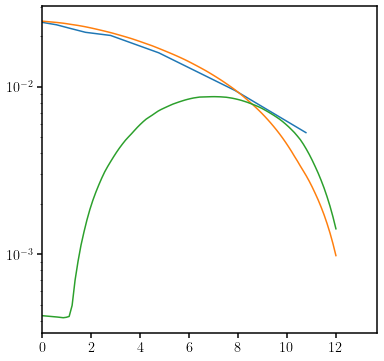

In [10]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.plot(meta['t_lookback'][igal], 
         (meta['Z_disk'][igal] * meta['sfh_disk'][igal] + meta['Z_bulge'][igal] * meta['sfh_bulge'][igal])/(meta['sfh_disk'][igal] + meta['sfh_bulge'][igal]))

theta_i[7] = 4.5e-3
theta_i[8] = 2e-3#7.84027029e-05#1e-2# 2.89134312e-03
t, zh = m_nmf.ZH(theta_i, zred=meta['redshift'][igal])
sub.plot(t, zh)
t, zh = m_nmf.ZH(theta_bf, zred=meta['redshift'][igal])
sub.plot(t, zh)
sub.set_xlim(0., 13.7)
sub.set_yscale('log')

In [68]:
theta_true = theta_i.copy()
theta_true[0] = meta['logM_fiber'][igal]

/Users/chahah/projects/provabgs/src/provabgs/models.py:850: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/Users/chahah/projects/provabgs/src/provabgs/models.py:909: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])


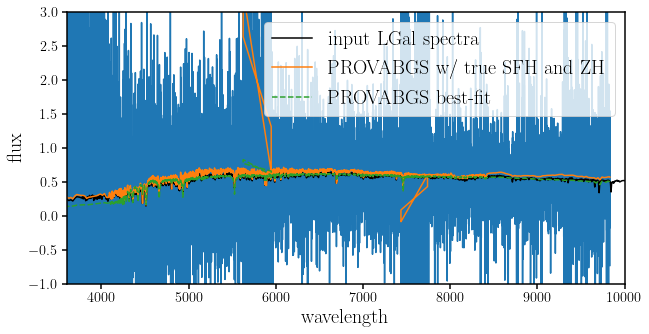

In [72]:
w, f = m_nmf.sed(theta_true, zred=meta['redshift'][igal], wavelength=spec_noise['wave'])
w_bf, f_bf = m_nmf.sed(theta_bf, zred=meta['redshift'][igal], wavelength=spec_noise['wave'])

fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(spec_noise['wave'], spec_noise['flux'][igal,:])
sub.plot(spec_nonoise['wave'], spec_nonoise['flux'][igal,:], c='k', label='input LGal spectra')
sub.plot(w, f, label='PROVABGS w/ true SFH and ZH')
sub.plot(w_bf, f_bf, ls='--', label='PROVABGS best-fit')
sub.set_xlabel('wavelength', fontsize=20)
sub.set_xlim(3.6e3, 1e4)
sub.set_ylabel('flux', fontsize=20)
sub.set_ylim(-1, 3)
sub.legend(loc='upper right', fontsize=20, frameon=True)

In [73]:
np.sum((spec_noise['flux'][igal,:] - f)**2 * spec_noise['ivar'][igal])

9116.390505389456

In [74]:
np.sum((spec_noise['flux'][igal,:] - np.interp(spec_noise['wave'], spec_nonoise['wave'], spec_nonoise['flux'][igal]))**2 * spec_noise['ivar'][igal])

8789.64985551564

### The $\chi^2$ is lower for the best-fit than `provabgs` run with the true SFH and ZH!

In [40]:
(spec_noise['flux'][igal,:] - f_bf)**2 #* spec_noise['ivar'][igal]

array([1.64610755e+01, 1.17736497e+02, 4.69454537e+01, ...,
       4.05690772e-02, 6.31524399e-01, 1.51125854e+00])

In [13]:
np.sum((spec_noise['flux'][igal,:] - f_bf)**2 * spec_noise['ivar'][igal])

8790.476381427363

Interesting. The best-fit from the S2 test actually matches the noiseless spectra quite well and has a higher likelihood.

# Lets check the inference
Lets run a chain without initializing the walkers and a chain with initializing the walkers

In [21]:
# set prior
prior = Infer.load_priors([
    Infer.UniformPrior(9., 12., label='sed'),
    Infer.FlatDirichletPrior(4, label='sed'),   # flat dirichilet priors
    Infer.UniformPrior(0., 1., label='sed'), # burst fraction
    Infer.UniformPrior(0., 13.27, label='sed'), # tburst
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(6.9e-5, 7.3e-3, label='sed'),# uniform priors on ZH coeff
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust1
    Infer.UniformPrior(0., 3., label='sed'),        # uniform priors on dust2
    Infer.UniformPrior(-2.2, 0.4, label='sed')     # uniform priors on dust_index
])


desi_mcmc = Infer.desiMCMC(model=m_nmf, prior=prior)

# run MCMC
zeus_chain0 = desi_mcmc.run(
    wave_obs=spec_noise['wave'],
    flux_obs=spec_noise['flux'][igal,:],
    flux_ivar_obs=spec_noise['ivar'][igal,:],
    zred=meta['redshift'][igal],
    vdisp=0., # 25 is roughly the median of the L-Galaxies mock
    sampler='zeus',
    nwalkers=30,
    burnin=0,
    opt_maxiter=2000,
    niter=5000,
    progress=True,
    debug=True)

--- initializing the walkers ---


/Users/chahah/projects/provabgs/src/provabgs/models.py:909: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
/Users/chahah/projects/provabgs/src/provabgs/models.py:850: RuntimeWarning: overflow encountered in exp
  layers.append((betas_[i] + (1.-betas_[i])*1./(1.+np.exp(-alphas_[i]*act[-1])))*act[-1])
Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/5000 [00:00<?, ?it/s]

initial theta = [9.000000007152384, 0.9987984989329278, 0.9217348090455177, 0.02491598796344374, 0.44019530783968924, 1.4147201203170208, 0.002910248880751165, 0.00124889807425045, 1.660068584908025, 0.5062929239327232, -1.5529192272210461]
log Posterior(theta0) = -4462.073120
--- running MCMC ---


Sampling progress : 100%|██████████| 5000/5000 [43:03<00:00,  1.94it/s]

bestfit theta = [9.191725416752687, 0.4026854186653207, 0.09139008273691446, 0.3500627048744152, 0.15586179372334957, 0.15374334262691242, 1.3644125669391645, 6.975997114963371e-05, 0.0014606479421201519, 2.5210189338593465, 0.6971535741138448, -0.7570761822325867]
log Posterior = -4395.173394
Model.sed: redshift = 0.136576
Model.sed: ssp lum [ 6101.88199174  6295.02185528  5898.70602799 ... 57923.91621212
 58069.00381477 58149.17674546]


In [22]:
theta_start = theta_i.copy()
theta_start[0] = meta['logM_fiber'][igal]
# run MCMC
zeus_chain1 = desi_mcmc.run(
    wave_obs=spec_noise['wave'],
    flux_obs=spec_noise['flux'][igal,:],
    flux_ivar_obs=spec_noise['ivar'][igal,:],
    zred=meta['redshift'][igal],
    theta_start=prior.untransform(theta_start),
    vdisp=0., # 25 is roughly the median of the L-Galaxies mock
    sampler='zeus',
    nwalkers=30,
    burnin=0,
    opt_maxiter=2000,
    niter=5000,
    progress=True,
    debug=True)

Initialising ensemble of 30 walkers...
Sampling progress :   0%|          | 0/5000 [00:00<?, ?it/s]

--- initializing the walkers ---
initial theta = [9.448093279956131, 0.5, 0.30000000000000004, 0.6666666666666667, 0.0, 0.0, 0.0045, 0.002, 0.5064289210369245, 0.2716541776628665, 0.0]
log Posterior(theta0) = -4558.195253
--- running MCMC ---


Sampling progress : 100%|██████████| 5000/5000 [58:48<00:00,  1.42it/s]  

bestfit theta = [9.14420707710653, 0.9008312700222567, 0.07206873982335531, 0.010174886929270214, 0.016925103225117703, 0.3980111654266899, 0.9884455145186986, 6.901165154179824e-05, 0.0013824203117997265, 1.4354617862947003, 0.7765882768806602, -0.5590422963732586]
log Posterior = -4394.602987
Model.sed: redshift = 0.136576
Model.sed: ssp lum [ 6468.64507637  6660.51390028  6382.75393434 ... 56274.20550957
 56452.12155178 56596.62346731]


Too few points to create valid contours


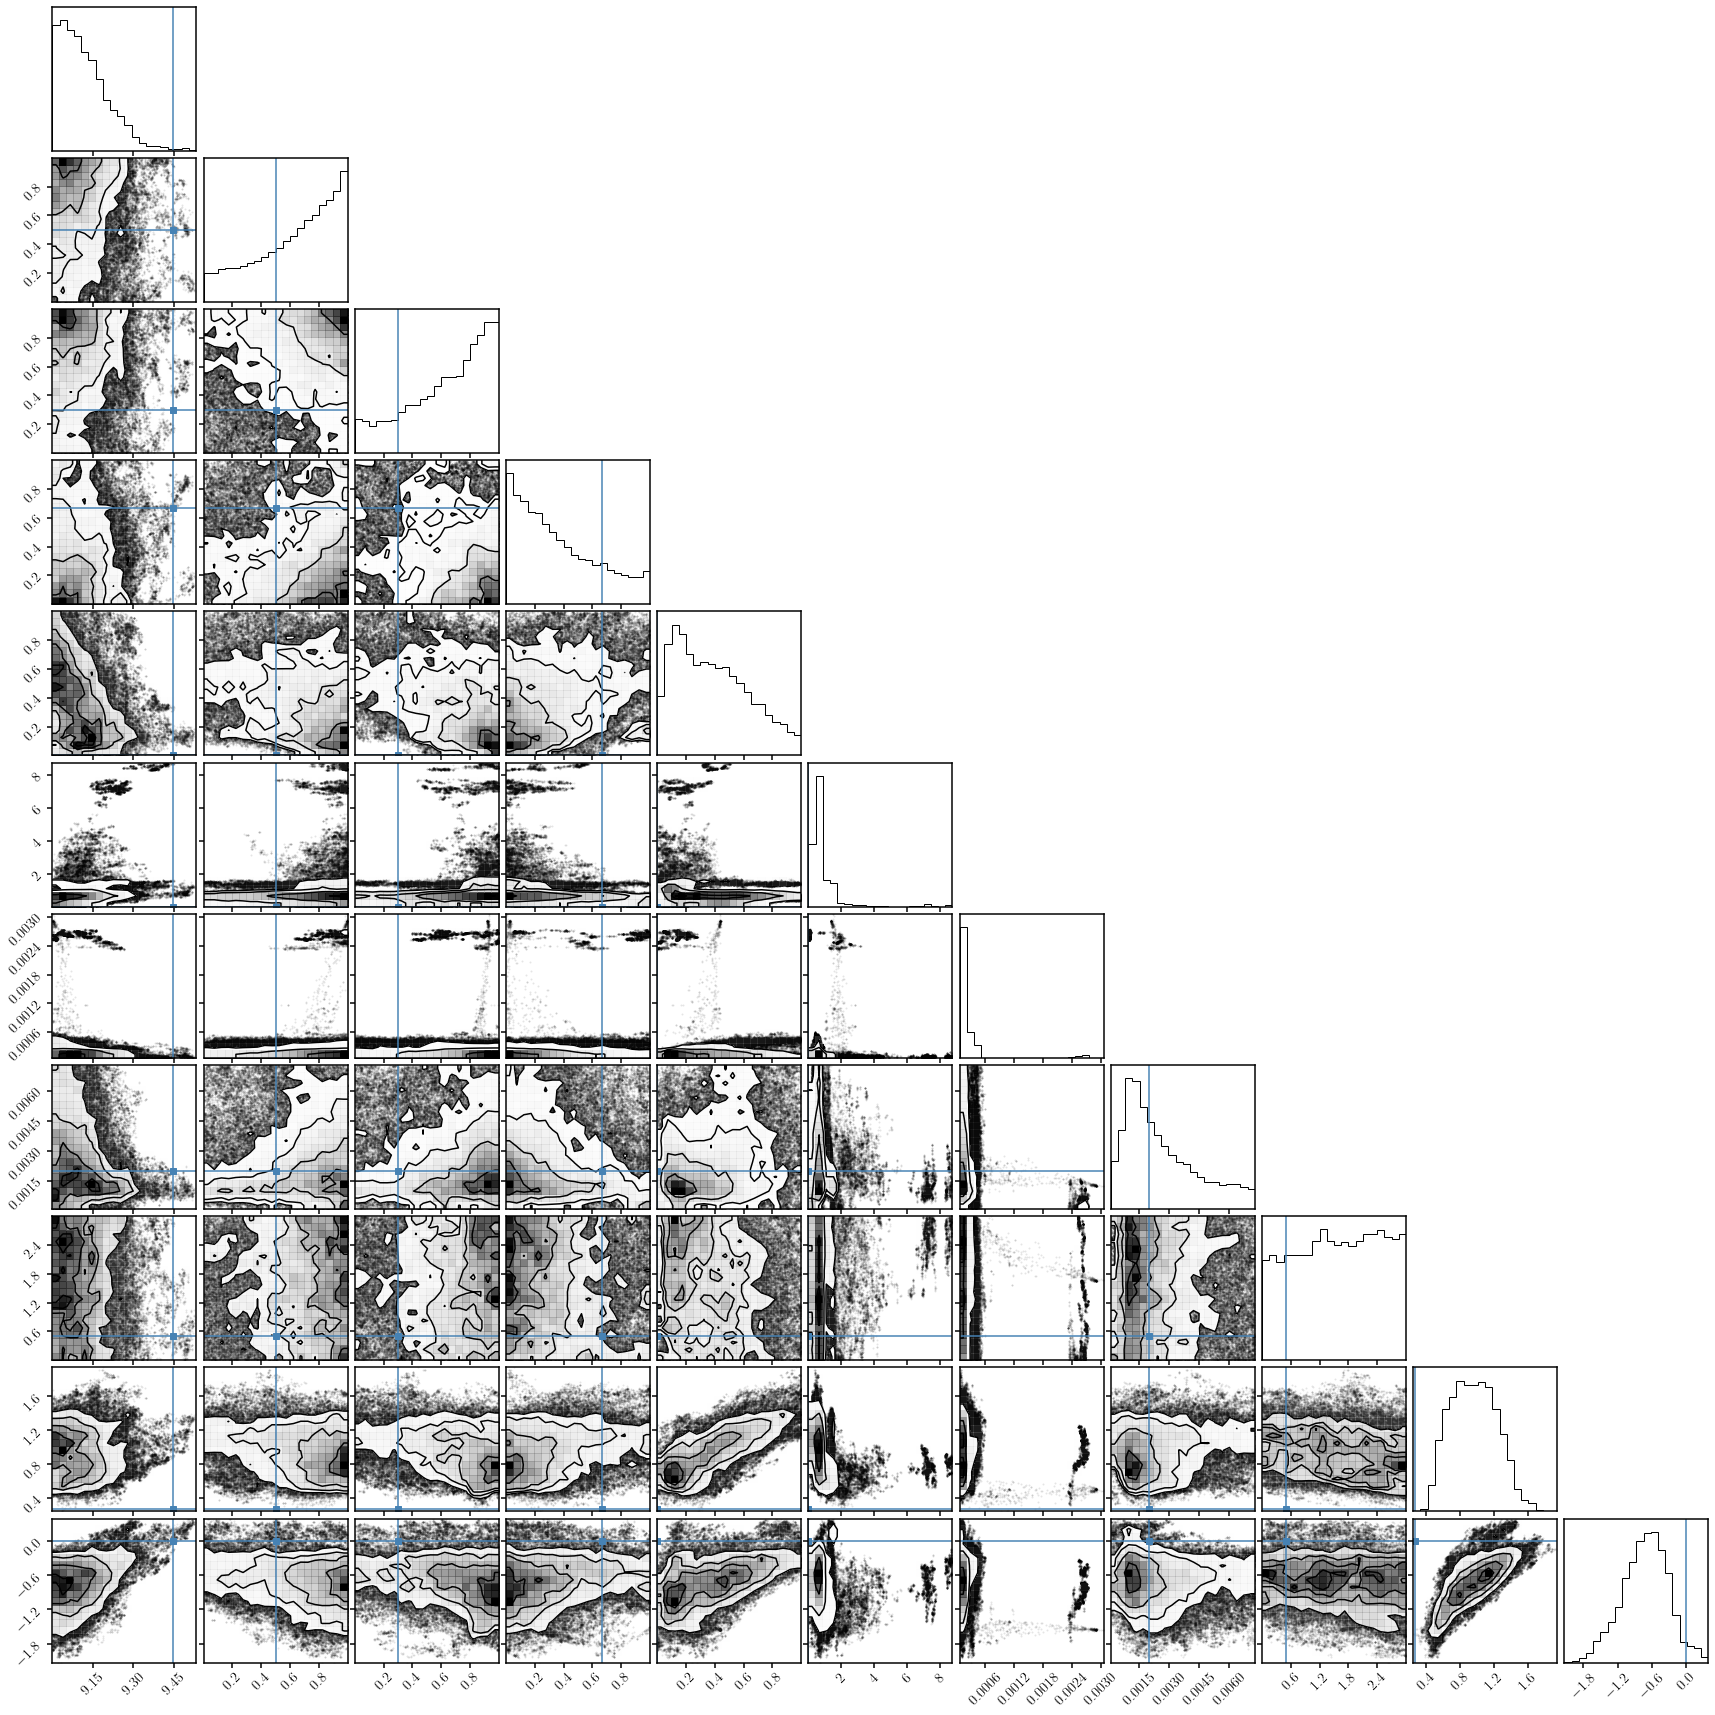

In [23]:
_ = DFM.corner(prior.untransform(desi_mcmc._flatten_chain(zeus_chain0['mcmc_chain'])), truths=prior.untransform(theta_start))

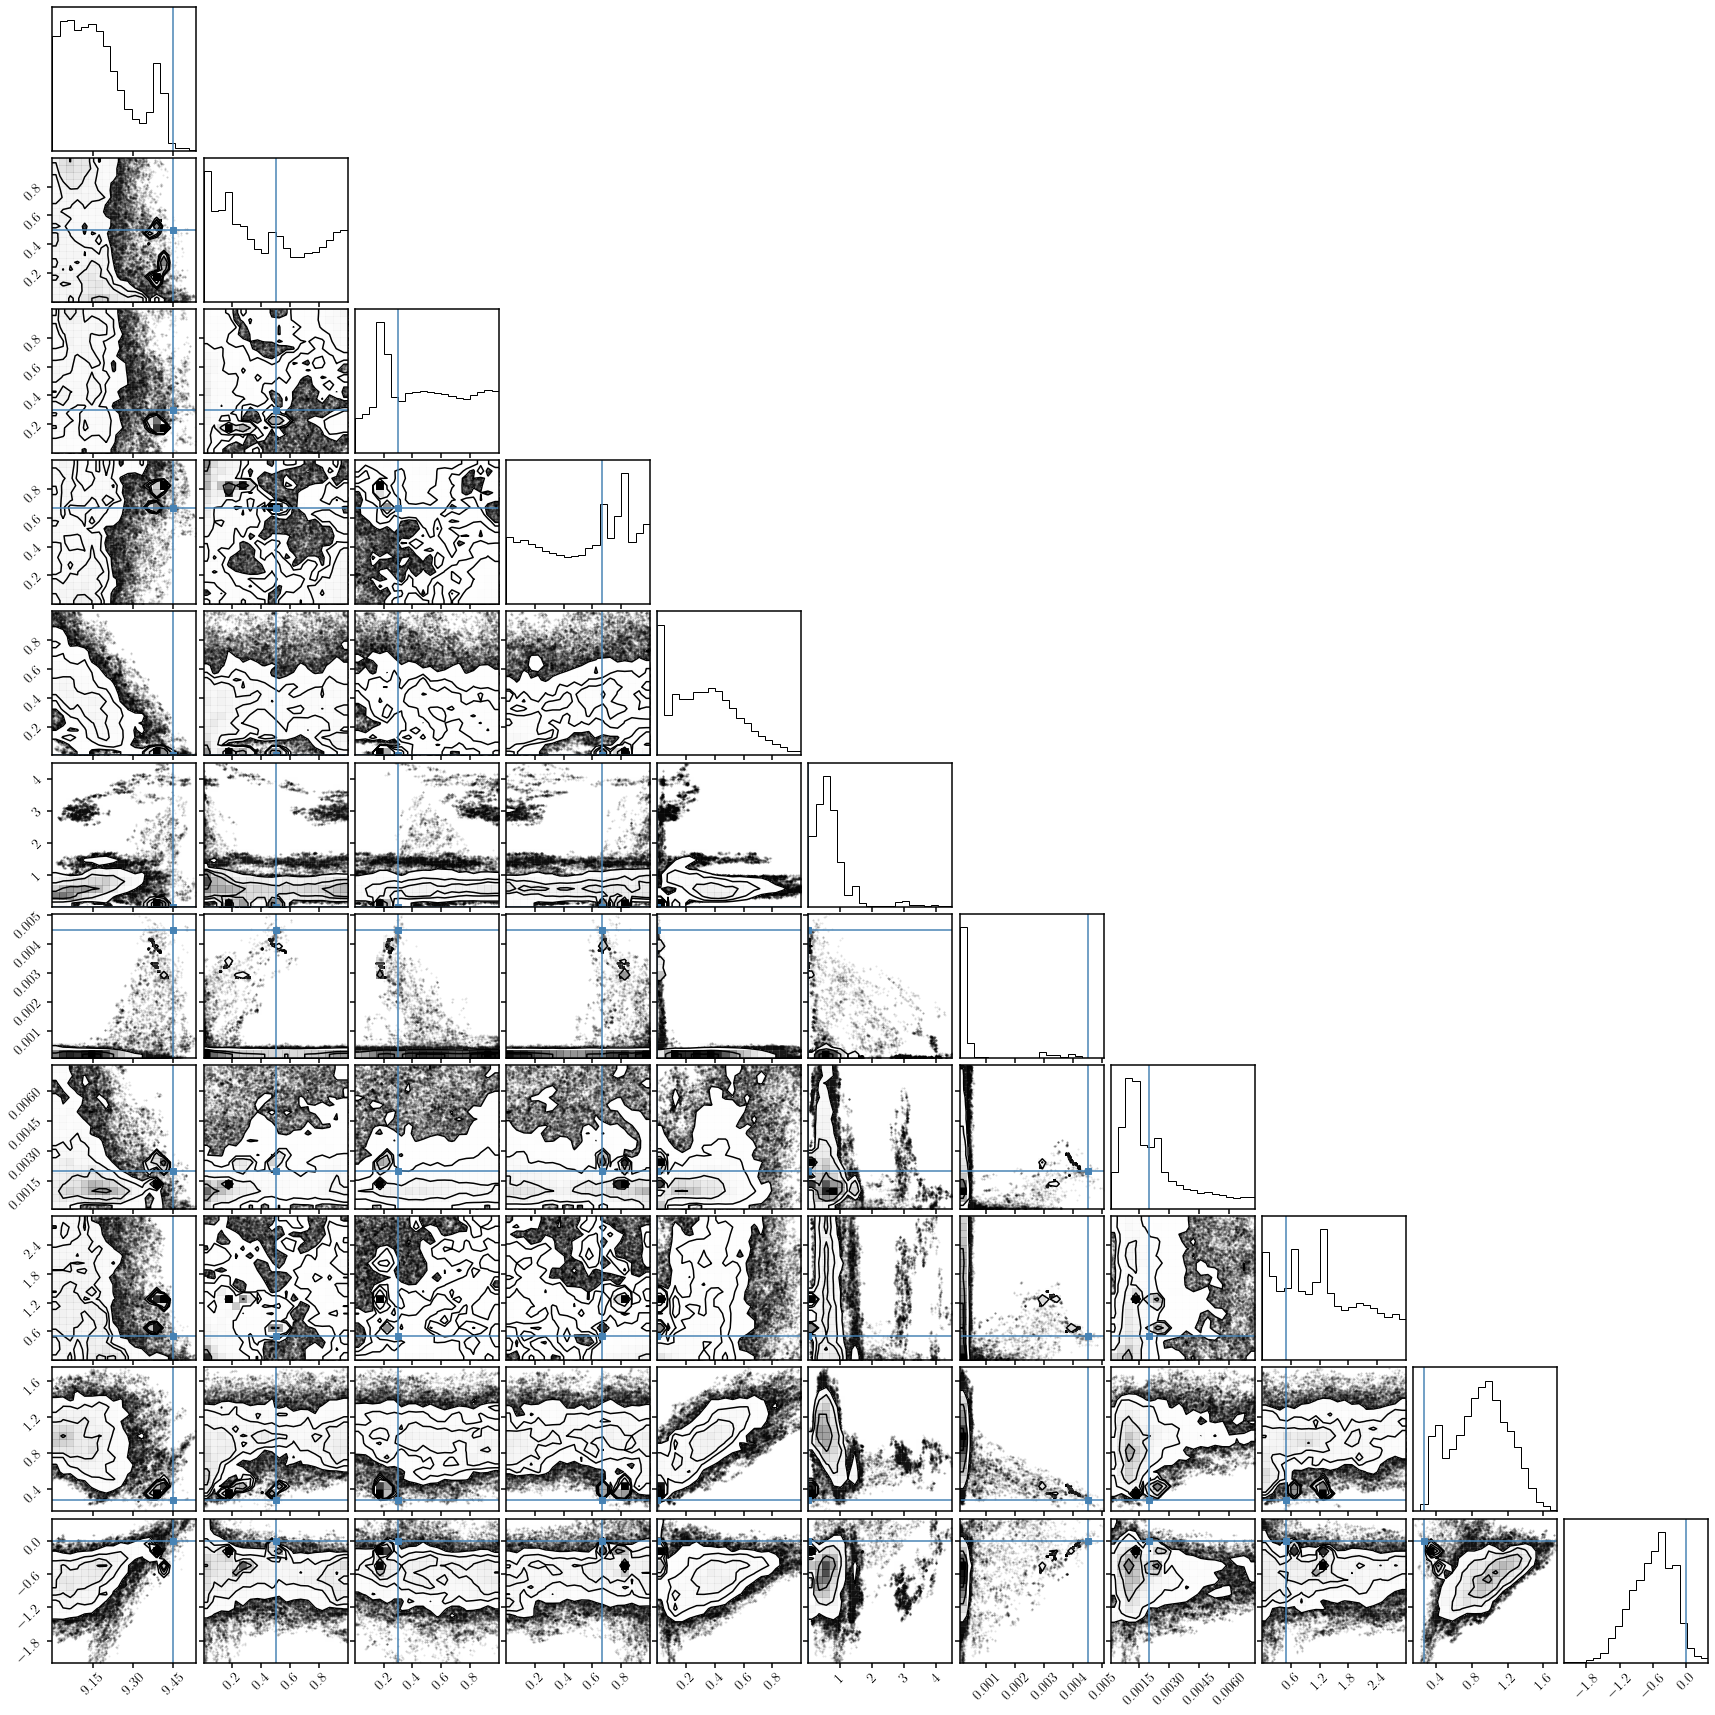

In [24]:
_ = DFM.corner(prior.untransform(desi_mcmc._flatten_chain(zeus_chain1['mcmc_chain'])), truths=prior.untransform(theta_start))

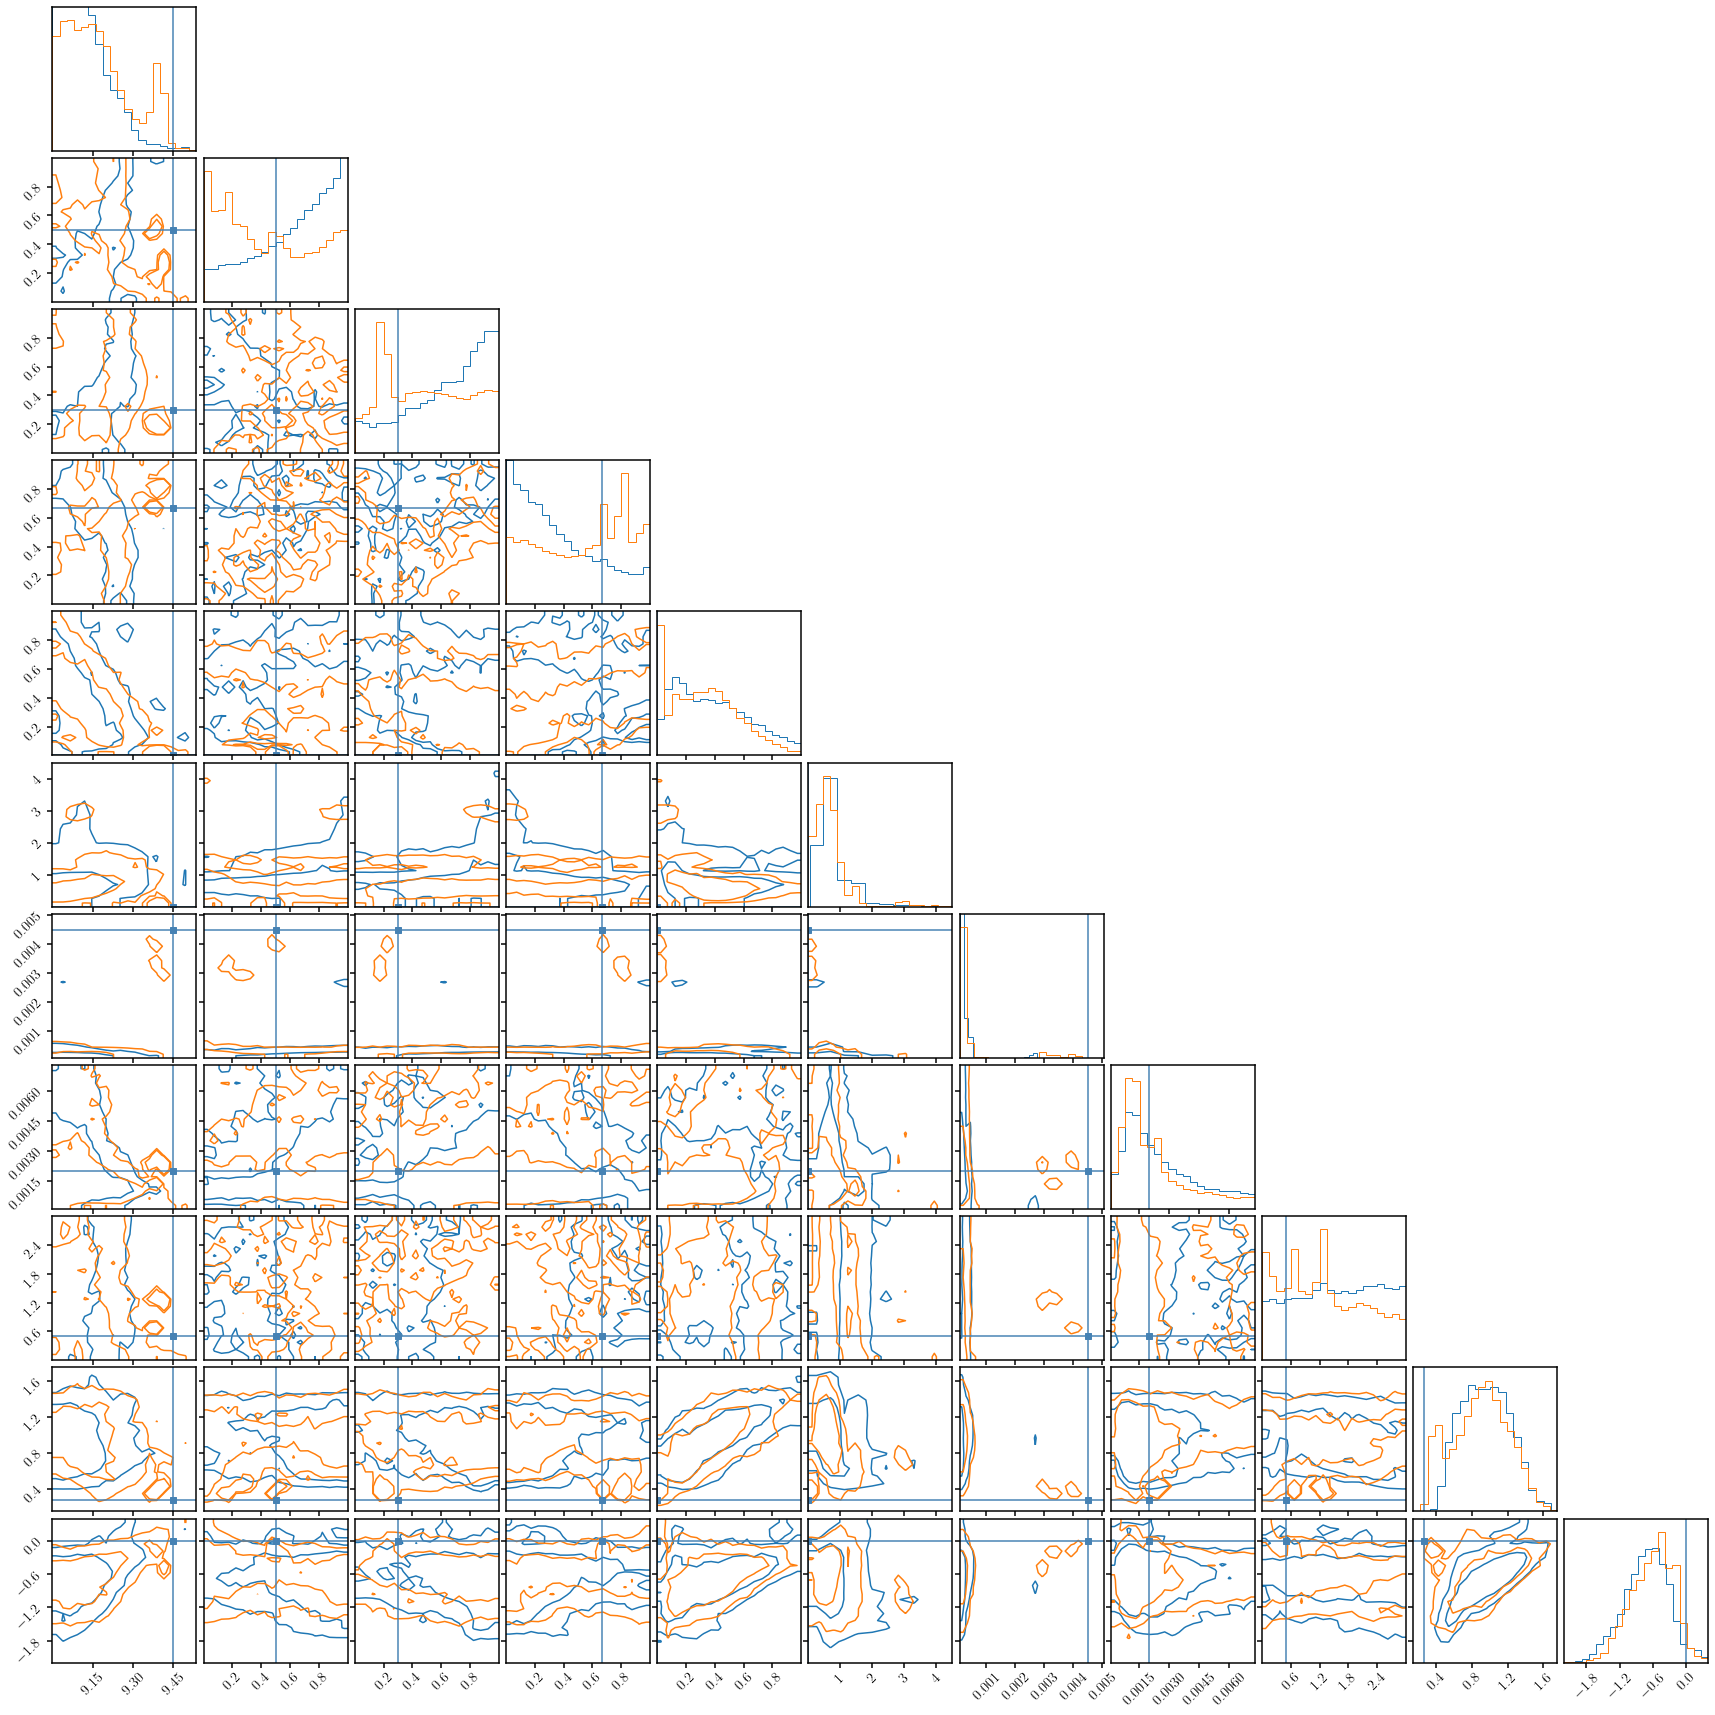

In [55]:
fig = DFM.corner(prior.untransform(desi_mcmc._flatten_chain(zeus_chain0['mcmc_chain'])), 
                 levels=[0.68, 0.95], color='C0', hist_kwargs={'density': True},
                 plot_datapoints=False, plot_density=False)

_ = DFM.corner(prior.untransform(desi_mcmc._flatten_chain(zeus_chain1['mcmc_chain'])), 
                   truths=prior.untransform(theta_start),
                   levels=[0.68, 0.95], color='C1', hist_kwargs={'density': True},
                   plot_datapoints=False, plot_density=False, fig=fig)

The initialization of the walkers don't seem to matter as much as I thought, but first 

## Lets compare the derived galaxy properties

In [66]:
logMstar_true = theta_start[0]
logSSFR_true = np.log10(m_nmf.avgSFR(theta_start, meta['redshift'][igal], dt=1.0)) - logMstar_true
logZ_MW_true = np.log10(m_nmf.Z_MW(theta_start, m_nmf.cosmo.age(meta['redshift'][igal]).value))
prop_true = np.array([logMstar_true, logSSFR_true, logZ_MW_true])

/opt/anaconda3/envs/gqp/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.


In [62]:
flat_chain0 = desi_mcmc._flatten_chain(zeus_chain0['mcmc_chain'])
logMstar_inf0 = flat_chain0[:,0]
logSSFR_inf0 = np.log10(m_nmf.avgSFR(flat_chain0, meta['redshift'][igal], dt=1.0)) - flat_chain0[:,0]
logZ_MW_inf0 = np.log10(m_nmf.Z_MW(flat_chain0, m_nmf.cosmo.age(meta['redshift'][igal]).value))
prop_inf0 = np.vstack([logMstar_inf0, logSSFR_inf0, logZ_MW_inf0]).T

In [63]:
flat_chain1 = desi_mcmc._flatten_chain(zeus_chain1['mcmc_chain'])
logMstar_inf1 = flat_chain1[:,0]
logSSFR_inf1 = np.log10(m_nmf.avgSFR(flat_chain1, meta['redshift'][igal], dt=1.0)) - flat_chain1[:,0]
logZ_MW_inf1 = np.log10(m_nmf.Z_MW(flat_chain1, m_nmf.cosmo.age(meta['redshift'][igal]).value))
prop_inf1 = np.vstack([logMstar_inf1, logSSFR_inf1, logZ_MW_inf1]).T

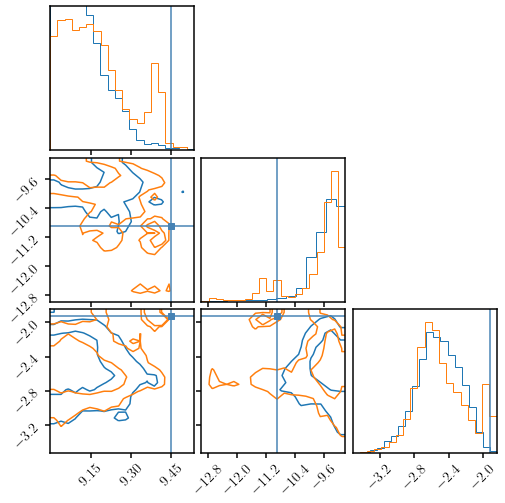

In [67]:
fig = DFM.corner(prop_inf0, 
                 levels=[0.68, 0.95], color='C0', hist_kwargs={'density': True},
                 plot_datapoints=False, plot_density=False)

_ = DFM.corner(prop_inf1, 
               truths=prop_true,
               levels=[0.68, 0.95], color='C1', hist_kwargs={'density': True},
               plot_datapoints=False, plot_density=False, fig=fig)

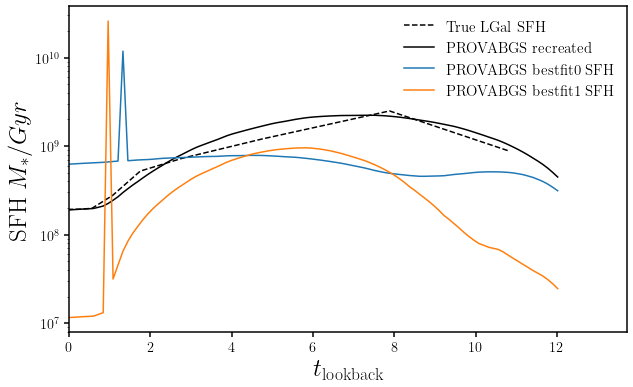

In [85]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.plot(meta['t_lookback'][igal], (meta['sfh_disk'][igal] + meta['sfh_bulge'][igal])/meta['dt'][igal], c='k', ls='--',
         label='True LGal SFH')

t, sfh = m_nmf.SFH(theta_true, zred=meta['redshift'][igal])
sub.plot(t, 10**(meta['logM_total'][igal]-meta['logM_fiber'][igal]) * sfh, c='k', 
        label='PROVABGS recreated')

t, sfh = m_nmf.SFH(zeus_chain0['theta_bestfit'], zred=meta['redshift'][igal])
sub.plot(t, 10**(meta['logM_total'][igal]-meta['logM_fiber'][igal]) * sfh, c='C0', 
        label='PROVABGS bestfit0 SFH')
t, sfh = m_nmf.SFH(zeus_chain1['theta_bestfit'], zred=meta['redshift'][igal])
sub.plot(t, 10**(meta['logM_total'][igal]-meta['logM_fiber'][igal]) * sfh, c='C1', 
        label='PROVABGS bestfit1 SFH')
sub.set_xlabel(r'$t_{\rm lookback}$', fontsize=25)
sub.set_xlim(0., 13.7)
sub.set_ylabel('SFH $M_*/Gyr$', fontsize=25)
sub.set_yscale('log')
sub.legend(loc='upper right', fontsize=15)

Once bursts are introduced there are so many degeneracies...